## 📦 **Import Libraries**

In [1]:
!pip install Sastrawi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 5.1 MB/s eta 0:00:00


In [2]:
import warnings
warnings.filterwarnings('ignore')

# mount drive
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import re, string

import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from wordcloud import WordCloud

# from googletrans import Translator
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory, StopWordRemover, ArrayDictionary
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

Mounted at /content/drive


## 🗃️ **Data Preparation**

In [4]:
dir = '/content/drive/MyDrive/Colab Notebooks/ml-stuff/data/'

projects = pd.read_csv(dir + 'projects_preprocessed_minimum.csv')

kamus_alay = pd.read_csv('https://raw.githubusercontent.com/nasalsabila/kamus-alay/master/colloquial-indonesian-lexicon.csv')
# kamus_alay = pd.read_csv(dir + 'colloquial-indonesian-lexicon.csv')
kamus_alay = kamus_alay.filter(['slang', 'formal'], axis = 1).drop_duplicates(subset = ['slang'])
kamus_alay_map = dict(zip(kamus_alay['slang'], kamus_alay['formal']))

#### 📂 **Dataset Information**

In [5]:
projects.head()

,Unnamed: 0,text_clean,finishDays,tags_token,budget
0,0,penulis yang tinggal di apartemen jakarta menu...,7.0,['Writing'],250000.0
1,1,membuat artikel di media online pekerjaan memb...,7.0,"['Blog', 'Blogspot', 'Content Management Syste...",350000.0
2,2,editing 12 shortt video untuk konten tiktok hi...,7.0,"['Social Media Marketing (SMM)', 'Adobe Illust...",200000.0
3,3,cari akun canva creator element atau template ...,7.0,"['Design Arts', 'Graphic Design', 'Logo Design...",1000000.0
4,4,cari jasa upload aplikasi ke app store sedang ...,7.0,['iPhone/iOS'],150000.0


## 📊 **Exploratory Data Analysis**

### **Missing Values Overview**

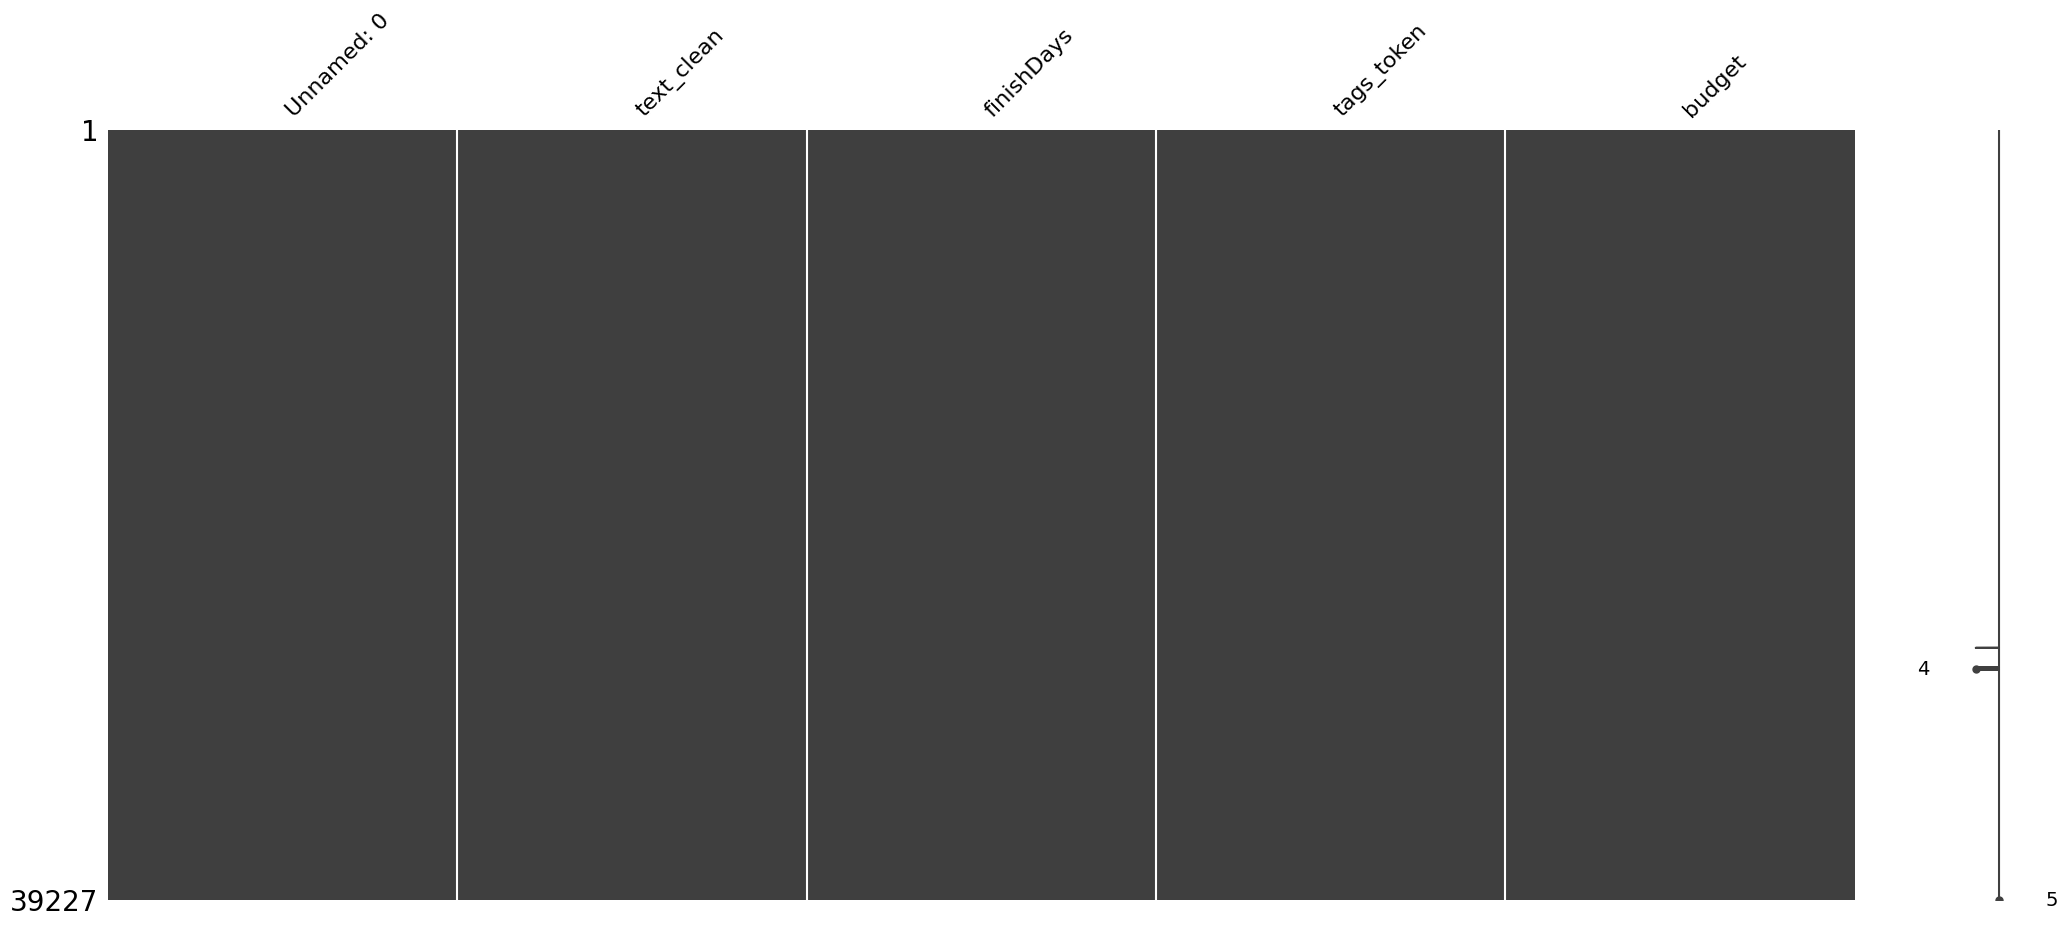

In [6]:
msno.matrix(projects)
plt.show()

In [7]:
round(projects.isna().mean().sort_values(ascending = False), 4)

text_clean    0.0001
Unnamed: 0    0.0000
finishDays    0.0000
tags_token    0.0000
budget        0.0000
dtype: float64

In [8]:
df = projects

In [9]:
df

,Unnamed: 0,text_clean,finishDays,tags_token,budget
0,0,penulis yang tinggal di apartemen jakarta menu...,7.0,['Writing'],250000.0
1,1,membuat artikel di media online pekerjaan memb...,7.0,"['Blog', 'Blogspot', 'Content Management Syste...",350000.0
2,2,editing 12 shortt video untuk konten tiktok hi...,7.0,"['Social Media Marketing (SMM)', 'Adobe Illust...",200000.0
3,3,cari akun canva creator element atau template ...,7.0,"['Design Arts', 'Graphic Design', 'Logo Design...",1000000.0
4,4,cari jasa upload aplikasi ke app store sedang ...,7.0,['iPhone/iOS'],150000.0
...,...,...,...,...,...
39222,39222,terjemahkan bahasa inggris ke bahasa indonesia...,7.0,['English'],600000.0
39223,39223,buatkan lagu buatkan lagu untuk genre anak ana...,7.0,['Cakewalk'],800000.0
39224,39224,pembuatan banner untuk promosi produk dalam uk...,5.0,['Graphic Design'],600000.0
39225,39225,edit foto editkan foto ini dan saya ingin hasi...,3.0,['Adobe PhotoShop'],250000.0


In [10]:
df.rename(columns = {'tags_token':'project_tags'}, inplace = True)
df.rename(columns = {'text_clean':'text'}, inplace = True)

##`project_tags`

In [11]:
# Filtering the rare terms.
df_filtered = df.groupby("project_tags").filter(lambda x: len(x) > 1)
df_filtered['project_tags']

0                                              ['Writing']
3        ['Design Arts', 'Graphic Design', 'Logo Design...
4                                           ['iPhone/iOS']
5                                              ['Writing']
6                 ['Data Entry', 'Quesioner', 'Responden']
                               ...                        
39221                                  ['Email Marketing']
39222                                          ['English']
39224                                   ['Graphic Design']
39225                                  ['Adobe PhotoShop']
39226                     ['CorelDRAW', 'Adobe PhotoShop']
Name: project_tags, Length: 27838, dtype: object

In [12]:
import ast 

df_filtered['project_tags'] = [ast.literal_eval(i) for i in df_filtered['project_tags']]
df_filtered['project_tags'].values[:5]

array([list(['Writing']),
       list(['Design Arts', 'Graphic Design', 'Logo Design', 'Canva']),
       list(['iPhone/iOS']), list(['Writing']),
       list(['Data Entry', 'Quesioner', 'Responden'])], dtype=object)

In [13]:
df_filtered['text'] = df_filtered['text'].astype(str)

In [14]:
df_filtered = df_filtered.drop('Unnamed: 0', axis = 1)

## Base Model

In [15]:
df_filtered

,text,finishDays,project_tags,budget
0,penulis yang tinggal di apartemen jakarta menu...,7.0,[Writing],250000.0
3,cari akun canva creator element atau template ...,7.0,"[Design Arts, Graphic Design, Logo Design, Canva]",1000000.0
4,cari jasa upload aplikasi ke app store sedang ...,7.0,[iPhone/iOS],150000.0
5,saya membutuhkan penulis untuk artikel zodiac ...,10.0,[Writing],200000.0
6,penyebaran kuesioner sleman saya membutuhkan j...,3.0,"[Data Entry, Quesioner, Responden]",150000.0
...,...,...,...,...
39221,data email kumpulkan data data email perusahaa...,12.0,[Email Marketing],1000000.0
39222,terjemahkan bahasa inggris ke bahasa indonesia...,7.0,[English],600000.0
39224,pembuatan banner untuk promosi produk dalam uk...,5.0,[Graphic Design],600000.0
39225,edit foto editkan foto ini dan saya ingin hasi...,3.0,[Adobe PhotoShop],250000.0


In [80]:
from sklearn.model_selection import train_test_split

test_split = 0.1

# Initial train and test split.
train_df, test_df = train_test_split(
    df_filtered,
    test_size=test_split,
    stratify=df_filtered["project_tags"].values,
)

# Splitting the test set further into validation
# and new test sets.
val_df = test_df.sample(frac=0.5)
test_df.drop(val_df.index, inplace=True)

print(f"Number of rows in training set: {len(train_df)}")
print(f"Number of rows in validation set: {len(val_df)}")
print(f"Number of rows in test set: {len(test_df)}")

Number of rows in training set: 25054
Number of rows in validation set: 1392
Number of rows in test set: 1392


In [81]:
test_df.to_csv(dir + "projects_test_df.csv", index=True)

In [17]:
train_df["text"].apply(lambda x: len(x.split(" "))).describe()

count    25054.000000
mean        60.326136
std         30.424439
min          1.000000
25%         35.000000
50%         58.000000
75%         82.000000
max        400.000000
Name: text, dtype: float64

In [18]:
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

In [19]:
terms = tf.ragged.constant(train_df["project_tags"].values)
lookup = tf.keras.layers.StringLookup(output_mode="multi_hot")
lookup.adapt(terms)
vocab = lookup.get_vocabulary()


def invert_multi_hot(encoded_labels):
    """Reverse a single multi-hot encoded label to a tuple of vocab terms."""
    hot_indices = np.argwhere(encoded_labels == 1.0)[..., 0]
    return np.take(vocab, hot_indices)


print("Vocabulary:\n")
print(vocab)

Vocabulary:

['[UNK]', 'Writing', 'PHP', 'Content Writer', 'Copywriter', 'Wordpress', 'Adobe PhotoShop', 'Data Entry', 'Search Engine Optimization (SEO)', 'Blog', 'Graphic Design', 'MySQL', 'Web Programming', 'Website', 'CodeIgniter', 'CorelDRAW', 'Android', 'Adobe Illustrator', 'Microsoft Word', 'HTML', 'Wordpress Templates', 'Laravel Framework', 'Logo Design', 'Web Design', 'CSS', 'Android studio', 'Internet Marketing', 'JavaScript', 'Website Building', 'Blogspot', 'Mobile Programming', 'Website Templates', 'Social Media Marketing (SMM)', 'English', 'Microsoft Excel', 'Video Editing', 'Video Production', 'Design Arts', 'Translation', 'Bootstrap', 'Market Research', 'Python', 'Web Research', 'Web Scrapping', 'Java', 'Instagram', 'Screenwriting', 'jQuery', 'Administration', 'Adobe Indesign', 'WooCommerce', 'Data Mining', 'Corel PhotoPaint', 'Facebook', 'E-Commerce', 'Data Analysis', 'Adobe Premiere', 'Adobe After Effects', 'Youtube', 'CSS Templates', 'Microsoft Office', 'Database Progr

In [20]:
sample_label = train_df["project_tags"].iloc[250]
print(f"Original label: {sample_label}")

label_binarized = lookup([sample_label])
print(f"Label-binarized representation: {label_binarized}")

Original label: ['Java', 'Android']
Label-binarized representation: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

In [21]:
max_seqlen = 150
batch_size = 128
padding_token = "<pad>"
auto = tf.data.AUTOTUNE


def make_dataset(dataframe, is_train=True):
    labels = tf.ragged.constant(dataframe["project_tags"].values)
    label_binarized = lookup(labels).numpy()
    dataset = tf.data.Dataset.from_tensor_slices(
        (dataframe["text"].values, label_binarized)
    )
    dataset = dataset.shuffle(batch_size * 10) if is_train else dataset
    return dataset.batch(batch_size)

In [22]:
train_dataset = make_dataset(train_df, is_train=True)
validation_dataset = make_dataset(val_df, is_train=False)
test_dataset = make_dataset(test_df, is_train=False)

In [44]:
test_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 38734), dtype=tf.float32, name=None), TensorSpec(shape=(None, 313), dtype=tf.float32, name=None))>

In [23]:
text_batch, label_batch = next(iter(train_dataset))

for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Text: {text}")
    print(f"Label(s): {invert_multi_hot(label[0])}")
    print(" ")

Text: b'dibutuhkan segera penulis 10 profil pengusaha pejabat dsb dibutuhkan segerapenulis pria wanita yang berpengalaman untuk menulis 10 profil pengusaha pejabat dosen dsb dari 80 profil yang direncanakan dengan kriteria sebab 1 setiap artikel profil terdiri darisekitar 950 kata nantinya akan dijadikan 3 halaman a4 setelah ditambahkanfoto2 dan setting huruf 2 tulisanharus menggunakan struktur yang baik dan benar tidak bosan membacanya menggunakanbahasa indonesia formal sesuai eyd serta seo fiendly 3 sudah ada rekaman wawancaranya tinggalbuat transkripnya'
Label(s): ['Writing']
 
Text: b'jasa upload apk webview ke play store cari jasa upload apk play store apk yang mau di upload apk webview carai yang sudah berhasil upload apk webview ke playstore sertakan contoh apk yang berhasil di upload apk webview'
Label(s): ['Website' 'Android' 'Android studio']
 
Text: b'desain logo saya butuh logo untuk brand baru saya yaitu banguninterior com logo menggambarkan bahwa kami adalah kontraktor in

In [24]:
vocabulary = set()
train_df["text"].str.lower().str.split().apply(vocabulary.update)
vocabulary_size = len(vocabulary)
print(vocabulary_size)

38734


In [25]:
text_vectorizer = layers.TextVectorization(
    max_tokens=vocabulary_size, ngrams=2, output_mode="tf_idf"
)

# `TextVectorization` layer needs to be adapted as per the vocabulary from our
# training set.
with tf.device("/CPU:0"):
    text_vectorizer.adapt(train_dataset.map(lambda text, label: text))

train_dataset = train_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)
validation_dataset = validation_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)
test_dataset = test_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)

In [26]:
def make_model():
    shallow_mlp_model = keras.Sequential(
        [   layers.Dense(512, activation="relu"),
            layers.Dense(256, activation="relu"),
            layers.Dense(lookup.vocabulary_size(), activation="sigmoid"),
        ]  # More on why "sigmoid" has been used here in a moment.
    )
    return shallow_mlp_model

In [27]:
epochs = 20

shallow_mlp_model = make_model()
shallow_mlp_model.compile(
    loss="binary_crossentropy", optimizer="adam", metrics=["binary_accuracy"]
)

history = shallow_mlp_model.fit(
    train_dataset, validation_data=validation_dataset, epochs=epochs
)

Epoch 1/20
196/196 [==============================] - 9s 20ms/step - loss: 0.0509 - binary_accuracy: 0.9846 - val_loss: 0.0175 - val_binary_accuracy: 0.9949
Epoch 2/20
196/196 [==============================] - 4s 22ms/step - loss: 0.0102 - binary_accuracy: 0.9968 - val_loss: 0.0167 - val_binary_accuracy: 0.9951
Epoch 3/20
196/196 [==============================] - 4s 20ms/step - loss: 0.0048 - binary_accuracy: 0.9986 - val_loss: 0.0184 - val_binary_accuracy: 0.9952
Epoch 4/20
196/196 [==============================] - 5s 23ms/step - loss: 0.0030 - binary_accuracy: 0.9993 - val_loss: 0.0211 - val_binary_accuracy: 0.9952
Epoch 5/20
196/196 [==============================] - 5s 25ms/step - loss: 0.0023 - binary_accuracy: 0.9995 - val_loss: 0.0219 - val_binary_accuracy: 0.9951
Epoch 6/20
196/196 [==============================] - 6s 29ms/step - loss: 0.0019 - binary_accuracy: 0.9996 - val_loss: 0.0235 - val_binary_accuracy: 0.9952
Epoch 7/20
196/196 [==============================] - 5s 2

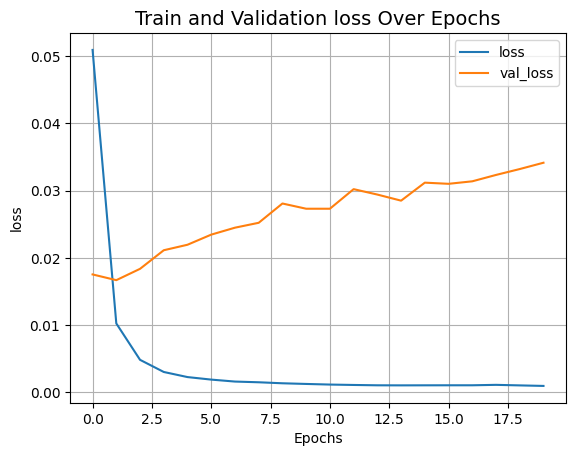

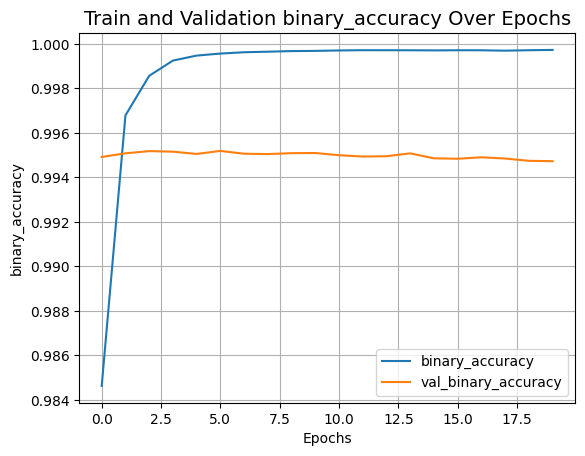

In [28]:
def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("binary_accuracy")

In [29]:
_, binary_acc = shallow_mlp_model.evaluate(test_dataset)
print(f"Categorical accuracy on the test set: {round(binary_acc * 100, 2)}%.")

11/11 [==============================] - 0s 13ms/step - loss: 0.0333 - binary_accuracy: 0.9947
Categorical accuracy on the test set: 99.47%.


## Saving Model

In [39]:
path = '/content/drive/MyDrive/Colab Notebooks/ml-stuff/model/projects/'

In [40]:
!mkdir -p saved_model
shallow_mlp_model.save(path + 'project_tags_model/my_model')

## Load Model

In [41]:
project_tags_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/ml-stuff/model/projects/project_tags_model/my_model')

## Prediction

In [82]:
# Create a model for inference.
model_for_inference = keras.Sequential([text_vectorizer, project_tags_model])

# Create a small dataset just for demoing inference.
inference_dataset = make_dataset(test_df.sample(100), is_train=False)
text_batch, label_batch = next(iter(inference_dataset))
predicted_probabilities = model_for_inference.predict(text_batch)

# Perform inference.
for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Text: {text}")
    print(f"Label(s): {invert_multi_hot(label[0])}")
    predicted_proba = [proba for proba in predicted_probabilities[i]]
    top_5_labels = [
        x
        for _, x in sorted(
            zip(predicted_probabilities[i], lookup.get_vocabulary()),
            key=lambda pair: pair[0],
            reverse=True,
        )
    ][:5]
    print(f"Predicted Label(s): ({', '.join([label for label in top_5_labels])})")
    print(" ")

4/4 [==============================] - 0s 5ms/step
Text: b'butuh video editor untuk video liputan hai freelancer saya membutuhkan seorang video editor untuk mengerjakan project liputan saya editing yang yang akan di kerjakan adalah liputan birthday party dengan 1 camera dan saya sertakan backup audionya juga file mentah yang akan di kerjakan kira-kira sekitar 60 70 gb an jadi saya berharap kepada freelancer yang sudah terpilih untuk bisa kita ketemuan untuk mencopy file2 tersebut just fyi lokasi saya ada di jakarta barat puri cl cp dan sekitar nya dan jakarta pusat mangga2 square dan sekitarnya hasil akhir yang saya mau adalah video file'
Label(s): ['Adobe PhotoShop' 'Video Editing' 'Video Production' 'Adobe Premiere'
 'Adobe After Effects']
Predicted Label(s): (Adobe PhotoShop, Video Production, Adobe After Effects, Adobe Premiere, Video Editing)
 
Text: b'butuh akun google adsense non hosted berumur tua mulai 2015 ke bawah dibutuhkan akun google adsense indonesia non hosted lama dash